# CNN Aproach

## Caveat: This notebook is intended to be run using Colab, and having the data in a Drive folder to which the user has access.

## Several sections of this file were inspired by this [notebook](https://github.com/random-forests/adl-fall-19/blob/master/a4.ipynb) written by Prof. Joshua Gordon.

## Import libraries

In [1]:
try:
    %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
    pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import os
import csv
import random
import time

In [0]:
import pandas as pd
import numpy as np

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
from google.colab import drive

In [0]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential

## Set paths

In [0]:
colab_root = "/content/" 
drive_root = "drive/My Drive/" + "ADL/" # CHANGE THIS TO THE DRIVE FOLDER WHERE YOU STORE THE DATA

In [9]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
labels_path = os.path.join(drive_root, "labels.csv")
images_path = os.path.join(drive_root, "clasico_frames.zip")

## Load data

In [0]:
!cp "$labels_path" .

In [0]:
!cp "$images_path" .

In [0]:
images_folder = os.path.join(colab_root, 'clasico_frames/')

In [0]:
!unzip -q clasico_frames.zip -d .

In [15]:
!ls

clasico_frames	clasico_frames.zip  drive  labels.csv  sample_data


## Data Wrangling

In [16]:
labels_df = pd.read_csv('labels.csv')
labels_df

,frame,label
0,0,0
1,10,0
2,20,0
3,30,0
4,40,0
...,...,...
8578,85780,3
8579,85790,3
8580,85800,3
8581,85810,3


In [17]:
def frame_num_to_image_path(frame):
    return(os.path.join(colab_root, "clasico_frames/frame%s.jpg" % frame))

labels_df['img_path'] = list(map(frame_num_to_image_path, labels_df['frame']))
labels_df

,frame,label,img_path
0,0,0,/content/clasico_frames/frame0.jpg
1,10,0,/content/clasico_frames/frame10.jpg
2,20,0,/content/clasico_frames/frame20.jpg
3,30,0,/content/clasico_frames/frame30.jpg
4,40,0,/content/clasico_frames/frame40.jpg
...,...,...,...
8578,85780,3,/content/clasico_frames/frame85780.jpg
8579,85790,3,/content/clasico_frames/frame85790.jpg
8580,85800,3,/content/clasico_frames/frame85800.jpg
8581,85810,3,/content/clasico_frames/frame85810.jpg


In [0]:
def get_human_label(label):
    if label == 0:
        return('death ball')
    elif label == 1:
        return('real madrid')
    elif label == 2:
        return('barcelona')
    elif label == 3:
        return('replay')

Tag: death ball


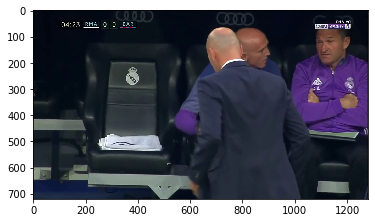

Tag: real madrid


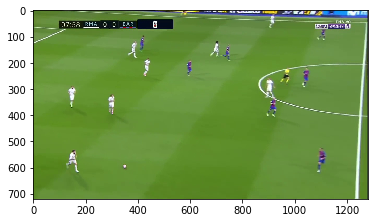

Tag: barcelona


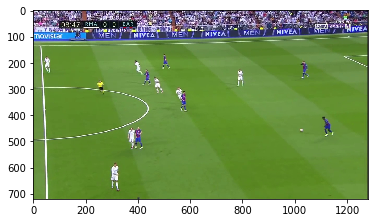

Tag: barcelona


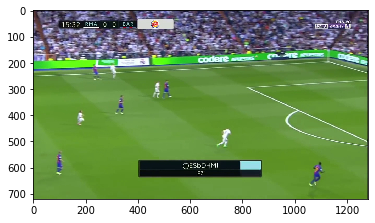

Tag: real madrid


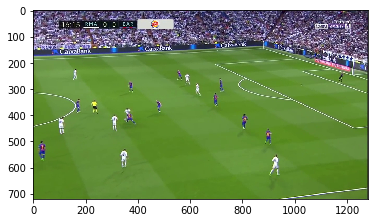

Tag: replay


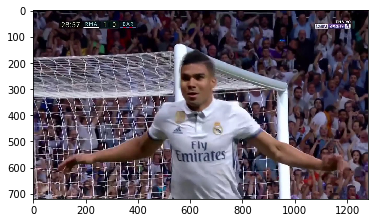

In [19]:
random.seed(1234)
for index, row in labels_df.iterrows():
    frame = row['frame']
    label = row['label']
    img_path = row['img_path']

    # Verify the image is in the folder
    assert os.path.exists(img_path)   

  # Shows some images
    if random.random() < 0.001:
        image_ = mpimg.imread(img_path)
        print('Tag: %s' % get_human_label(label))
        plt.gca().clear()
        plt.imshow(image_)
        plt.show()      

## Split train, validation and test 

We are going to train using only the first 15 minutes, and see if we can predict the next 30.

In [0]:
FRAME_THRESHOLD = 2725 #First 15 minutes
train_val = labels_df[:FRAME_THRESHOLD]
test = labels_df[FRAME_THRESHOLD:]
train, val = train_test_split(train_val, test_size=0.2, random_state=2019)

In [21]:
test

,frame,label,img_path
2725,27250,1,/content/clasico_frames/frame27250.jpg
2726,27260,1,/content/clasico_frames/frame27260.jpg
2727,27270,1,/content/clasico_frames/frame27270.jpg
2728,27280,1,/content/clasico_frames/frame27280.jpg
2729,27290,1,/content/clasico_frames/frame27290.jpg
...,...,...,...
8578,85780,3,/content/clasico_frames/frame85780.jpg
8579,85790,3,/content/clasico_frames/frame85790.jpg
8580,85800,3,/content/clasico_frames/frame85800.jpg
8581,85810,3,/content/clasico_frames/frame85810.jpg


## Save activations from Inception V3 for all the images

In [22]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 3s 0us/step


In [0]:
# A method to load an image off disk, and extract activations using 
# the model above. 
def image_to_activations(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    activations = tf.keras.applications.inception_v3.preprocess_input(img)
    return activations, image_path

In [24]:
image_path_set = set(labels_df['img_path'])

print("Images to preprocess", len(image_path_set))
print("This make take a few minutes")

Images to preprocess 8583
This make take a few minutes


In [0]:
# This cell will extract activations for each image and save them to disk 
# in NumPy format. 

# Create a dataset to load each image off disk, and extract activations
activation_dataset = tf.data.Dataset.from_tensor_slices(list(image_path_set))
activation_dataset = activation_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Save all activations to disk in NumPy format
for img_batch, path_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())  

## Convert data to an appropiate batch format to train the model

In [0]:
labels_train = list([1.0 * label for label in train['label']]) 
images_train = list(train['img_path']) 

labels_val = list([1.0 * label for label in val['label']]) 
images_val = list(val['img_path']) 

labels_test = list([1.0 * label for label in test['label']]) 
images_test = list(test['img_path']) 

In [0]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [0]:
def load_np(img_path, label):
    activations = np.load(img_path.decode('utf-8')+'.npy')
    return activations, label, img_path

def create_dataset(images, labels, shuff = True):
    dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                  labels))
    # Load the cached activations off disk
    dataset = dataset.map(lambda x, y: tf.numpy_function(
        load_np, [x, y], [tf.float32, tf.float32, tf.string]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Shuffle and batch
    if shuff:
        dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    else:
        dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
train_ds = create_dataset(images_train, labels_train)
val_ds = create_dataset(images_val, labels_val)
test_ds = create_dataset(images_test, labels_test, shuff = False)

In [30]:
my_iterator = iter(train_ds)
activations_batch, labels_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      labels_batch.shape, 
      paths_batch.shape)

print(activations_batch, 
      labels_batch, 
      paths_batch)

(32, 8, 8, 2048) (32,) (32,)
tf.Tensor(
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.62088513e-01
    0.00000000e+00 0.00000000e+00]
   [1.27009168e-01 2.60587543e-01 0.00000000e+00 ... 8.42514932e-01
    0.00000000e+00 0.00000000e+00]
   [3.80397707e-01 1.72975850e+00 0.00000000e+00 ... 1.33459818e+00
    0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 3.90338041e-02 0.00000000e+00 ... 2.70797443e+00
    8.33130442e-03 0.00000000e+00]
   [2.57932127e-01 0.00000000e+00 0.00000000e+00 ... 1.99476779e+00
    3.36046785e-01 0.00000000e+00]
   [0.00000000e+00 2.69593894e-01 0.00000000e+00 ... 1.61608887e+00
    5.88114917e-01 0.00000000e+00]]

  [[1.76843479e-01 0.00000000e+00 0.00000000e+00 ... 4.03554052e-01
    0.00000000e+00 4.36061859e-01]
   [1.53056979e+00 7.58918285e-01 0.00000000e+00 ... 3.78870785e-01
    0.00000000e+00 2.08862424e-01]
   [1.78626585e+00 1.32658851e+00 0.00000000e+00 ... 4.73144293e-01
    0.00000000e+00 1.52343482e-01]
   ...
   [7.48578906e-0

## Design the CNN

In [0]:
image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image = vision_model(image_input) 

# Add dense layers between the activations and the output
dense = Dense(64, activation='relu')(encoded_image)
dense = Dense(64, activation='relu')(dense)

# Next, add a binary classifier on top
output = Dense(4, activation='softmax')(dense)

# Your final model
model = Model(inputs=image_input, outputs=output)

In [65]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8, 8, 2048)]      0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 135,556
Trainable params: 135,556
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

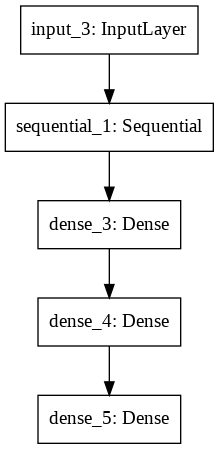

In [67]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

## Train on a single batch to verify everything is working

In [0]:
# Retrieve a batch of data from your train dataset
activations_batch, labels_batch, paths_batch = next(iter(train_ds))

In [0]:
for i in range(100):
  metrics = model.train_on_batch(activations_batch, labels_batch)

In [70]:
print('Loss: %f' % metrics[0])
print('Accuracy: %f' % metrics[1])

Loss: 0.001314
Accuracy: 1.000000


In [71]:
for prediction, label in zip(model.predict(x=activations_batch), labels_batch):
  print(prediction, label.numpy())

[4.3428878e-07 9.9928975e-01 6.7824114e-04 3.1552874e-05] 1.0
[9.9882275e-01 5.6976311e-05 1.1180305e-03 2.1853043e-06] 0.0
[1.5155134e-03 4.2961130e-04 9.9779046e-01 2.6445911e-04] 2.0
[6.8444045e-08 3.5067406e-04 9.9963987e-01 9.4542447e-06] 2.0
[1.0725546e-03 9.9736303e-01 1.2664197e-03 2.9794330e-04] 1.0
[6.2004576e-05 9.9869591e-01 1.1953632e-03 4.6711604e-05] 1.0
[4.5797362e-05 1.2455486e-03 9.9849176e-01 2.1690750e-04] 2.0
[2.40066950e-03 2.11222665e-04 9.97267842e-01 1.20320285e-04] 2.0
[8.1269821e-04 2.4263321e-05 9.9795002e-01 1.2130509e-03] 2.0
[2.2271763e-05 8.7351371e-05 9.3819690e-04 9.9895215e-01] 3.0
[4.1281444e-04 9.9899536e-01 3.9677098e-04 1.9506882e-04] 1.0
[1.0489209e-05 3.9206195e-04 2.5839629e-04 9.9933904e-01] 3.0
[4.5947163e-06 1.2710288e-03 9.9871922e-01 5.2791943e-06] 2.0
[3.2099438e-04 1.3165902e-03 2.3708537e-03 9.9599165e-01] 3.0
[6.1472388e-06 1.1726126e-04 9.9986684e-01 9.7463499e-06] 2.0
[2.2297738e-06 3.7651055e-04 4.1774724e-04 9.9920350e-01] 3.0
[5.5

## Manage checkpoints in case we want to fit the model for a long time

In [72]:
checkpoint_dir = os.path.join(drive_root, "soccer_checkpoints/CNN")
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
    print("Checkpoints folder already exists")
else:
    print("Creating a checkpoints directory")
    os.makedirs(checkpoint_dir)

Checkpoints directory is drive/My Drive/ADL/soccer_checkpoints/CNN
Creating a checkpoints directory


In [73]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


## Fit the model

In [0]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [0]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, label_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [76]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 50 

# Training loop
for epoch in range(epochs):

    start = time.time()

    # Train for one epoch
    for activation_batch, label_batch, path_batch in train_ds:
        result = model.train_on_batch(x=activation_batch, y=label_batch)

        # Record metrics after each batch
        train_loss(result[0])
        train_accuracy(result[1])

    # Evaluate for a few steps
    evaluate(max_steps=100)

    # Print progress
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100,
                          time.time() - start))
    
    # Record history
    train_loss_history.append(train_loss.result())
    train_acc_history.append(train_accuracy.result() * 100)
    val_loss_history.append(val_loss.result())
    val_acc_history.append(val_accuracy.result() * 100)

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Save a checkpoint after each epoch
    print("Saving weights")
    model.save_weights(checkpoint_path.format(epoch=epoch))

Epoch 0, Loss: 1.03, Accuracy: 60.73, Val Loss 0.76, Val Accuracy 71.38, Time: 4.6 secs
Saving weights
Epoch 1, Loss: 0.66, Accuracy: 74.09, Val Loss 0.66, Val Accuracy 74.50, Time: 4.6 secs
Saving weights
Epoch 2, Loss: 0.55, Accuracy: 78.76, Val Loss 0.58, Val Accuracy 77.43, Time: 4.6 secs
Saving weights
Epoch 3, Loss: 0.49, Accuracy: 80.84, Val Loss 0.60, Val Accuracy 75.60, Time: 4.6 secs
Saving weights
Epoch 4, Loss: 0.46, Accuracy: 82.02, Val Loss 0.61, Val Accuracy 75.78, Time: 4.6 secs
Saving weights
Epoch 5, Loss: 0.38, Accuracy: 85.73, Val Loss 0.46, Val Accuracy 82.75, Time: 4.5 secs
Saving weights
Epoch 6, Loss: 0.33, Accuracy: 87.36, Val Loss 0.46, Val Accuracy 80.55, Time: 4.5 secs
Saving weights
Epoch 7, Loss: 0.28, Accuracy: 90.08, Val Loss 0.42, Val Accuracy 84.04, Time: 4.6 secs
Saving weights
Epoch 8, Loss: 0.26, Accuracy: 90.90, Val Loss 0.74, Val Accuracy 71.38, Time: 4.5 secs
Saving weights
Epoch 9, Loss: 0.24, Accuracy: 91.44, Val Loss 0.44, Val Accuracy 83.67, 

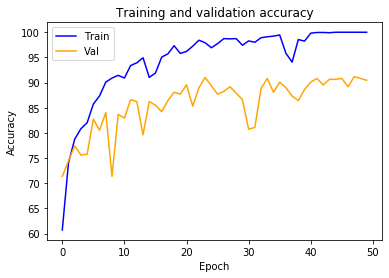

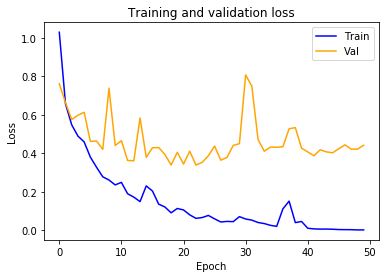

In [77]:
def plot(loss, acc, val_loss, val_acc):
  
  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

## Predict on the test dataset and save results

In [78]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

loaded weights from drive/My Drive/ADL/soccer_checkpoints/CNN/cp-00000049.ckpt


In [79]:
random.seed(2021)
acc_list = list()
predictions_list = list()
confidences_list = list()
paths_list = list()

for activation_batch, label_batch, path_batch in test_ds:
    score, acc = model.evaluate(activation_batch, label_batch, verbose=0)
    acc_list.append(acc)
    
    preds = model.predict(activation_batch)
    predictions_batch = list(np.argmax(preds, axis = 1))
    confidences_batch = list(np.max(preds, axis = 1))
    paths_batch = list(path_batch.numpy())
    paths_batch = [path.decode('utf-8') for path in paths_batch]
    labels_batch = list(label_batch.numpy())

    predictions_list = predictions_list + predictions_batch
    confidences_list = confidences_list + confidences_batch
    paths_list = paths_list + paths_batch

    for i in range(len(labels_batch)):
        if random.random() < 0.002:
            print('True label: %s' % get_human_label(labels_batch[i]))
            print('Predicted label: %s' % get_human_label(predictions_batch[i]))
            print('Confidence of the prediction: %s' % confidences_batch[i])
            image_ = mpimg.imread(paths_batch[i])
            plt.gca().clear()
            plt.imshow(image_)
            plt.show()     

Output hidden; open in https://colab.research.google.com to view.

In [80]:
print('The test accuracy is: %f' % np.mean(acc_list))

The test accuracy is: 0.554178


In [0]:
preds_df = pd.DataFrame({'img_path': paths_list,
                         'pred_label': predictions_list,
                         'confidence': confidences_list      
})

In [88]:
predictions_cnn = test.set_index('img_path').join(preds_df.set_index('img_path')).reset_index()
predictions_cnn

,img_path,frame,label,pred_label,confidence
0,/content/clasico_frames/frame27250.jpg,27250,1,0,0.851303
1,/content/clasico_frames/frame27260.jpg,27260,1,0,0.879458
2,/content/clasico_frames/frame27270.jpg,27270,1,1,0.999316
3,/content/clasico_frames/frame27280.jpg,27280,1,0,0.572468
4,/content/clasico_frames/frame27290.jpg,27290,1,2,0.968415
...,...,...,...,...,...
5853,/content/clasico_frames/frame85780.jpg,85780,3,0,0.936655
5854,/content/clasico_frames/frame85790.jpg,85790,3,3,0.999839
5855,/content/clasico_frames/frame85800.jpg,85800,3,3,0.999843
5856,/content/clasico_frames/frame85810.jpg,85810,3,3,0.989938


In [0]:
predictions_cnn.to_csv('predictions_cnn.csv', index = False)

In [0]:
!cp predictions_cnn.csv "$drive_root"